## **RADI608: Data Mining and Machine Learning**

### Assignment: Semi-Supervised Learning
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI608/tree/main/Submitted)

##   <code>Question 1</code>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from scipy.io import arff
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from time import time
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

import random
import warnings
warnings.filterwarnings('ignore')

rng = np.random.RandomState(10)

### Question 1a. From <code>colon.csv</code>, please reduce data dimension by using 2 features (column’s name or gene#: <code>T62947</code> and <code>H64807</code>).

##### We created a function called <code>load_colon</code> to acquire colon data with the relevant gene numbers. We then converted it to a numpy array and returns as <code>X, y</code>. The function <code>load_colon</code> will also be used in the later questions. 

In [2]:
def load_colon(path = '../data/colon.csv'):
    colon_data = pd.read_csv(path)
    X = colon_data[['T62947', 'H64807']].to_numpy()
    y = colon_data[['Class']].to_numpy()
    return X, y 
X, y = load_colon()

### Question 1b. Generate labeled and unlabeled data by random selecting 42 samples without replacement and removing their class to perform as unlabeled data. The non-selected 20 samples will be used as labeled data (42:20).

##### We also created the function <code>generate_labeled</code> that requires the dataset from <code>load_colon</code>, including the percentage of samples to be converted into unlabeled data. For this example, we inputted a <code>68%</code> unlabeled data, i.e., 42 samples. This function returns the non-selected 20 samples as labeled data. However, it will return both labeled and unlabeled datta once <code>include_unlabeled = True</code>. 

In [3]:
def generate_labeled(X, y, rate = 0.68, include_unlabeled = False):
    random.seed(30)
    size = int(np.round(X.shape[0] * rate))
    index = random.sample(range(len(y)), size)
    labeled = random.sample([x for x in range(X.shape[0]) if x not in index], X.shape[0] - size)
    X_labeled, y_labeled = X[labeled], y[labeled]

    assert X_labeled.shape[0] == y_labeled.shape[0]

    if include_unlabeled == True:
        X_unlabel, y_unlabel = X, y.copy()
        y_unlabel[index] = 0
        return X_labeled, y_labeled, X_unlabel, y_unlabel 
    return X_labeled, y_labeled

X_labeled, y_labeled = generate_labeled(X, y, rate =  0.68)

### Question 1c. Perform SVM by using 20 labelled samples.

##### In this code, the SVM model was trained using a function we created called <code>svm_train</code> that requires the dataset <code>X, y</code>. We used the results of the tuned parameters <code>C</code> and <code>gamma</code> from the previous assignment to train the SVM classifier. The function also prints the resulting <code>classification_report</code> of the ground truth versus model predictions.

In [4]:
def svm_train(X, y):
    assert X_labeled.shape[0] == y_labeled.shape[0]
    random.seed(413)
    svclassifier = SVC(kernel = 'rbf', C = 100, gamma = 1)
    svclassifier.fit(X, y)
    predictions = svclassifier.predict(X)
    print(classification_report(y, predictions, target_names = ['No Cancer', 'Cancer']))
    return svclassifier

svclassifier = svm_train(X_labeled, y_labeled)

              precision    recall  f1-score   support

   No Cancer       1.00      1.00      1.00        11
      Cancer       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Question 1d. Perform Label Propagation at label spreading 30%, 50%, and 70% by using Python and data from <code>Question 1a</code>. Random replace the original 62 samples.

##### Prior to Label Spreading, we created the function <code>label_propagate</code> since we will also use this function for Question 2. This function requires the dataset <code>X, y</code> and its corresponding <code>rate</code> of Label Spread as given in the problem above. We performed label propogation at label spreading <code>30%, 50%, </code> and <code>70%</code>.

In [5]:
def label_propagate(X, y, rate):
    y_new = np.copy(y)
    y_new[rng.rand(len(y)) < rate] = 0
    ls_ix = (LabelSpreading().fit(X, y_new), y_new)
    ls_ix = (ls_ix[0], ls_ix[1].ravel())
    return y_new, ls_ix

y30, ls30 = label_propagate(X, y, rate = 0.30)
y50, ls50 = label_propagate(X, y, rate = 0.50)
y75, ls70 = label_propagate(X, y, rate = 0.70)

rbf_svc = (SVC(kernel = 'rbf', C = 100, gamma = 1).fit(X, y), y)

### Question 1e. Compare and discuss the model performance from <code>Question 1c</code> and <code>Question 1d</code> by plotting two-dimension graph with decision boundary.

In [6]:
def plot_data(X, y):
    y = y.flatten()
    class1 = (y ==  1)
    class2 = (y == -1)
    plt.figure(figsize=(8, 5))    
    plt.plot(X[:,0][class1], X[:, 1][class1], 'ro', markersize = 8, label = 'With Disease')
    plt.plot(X[:,0][class2], X[:, 1][class2], 'bo', markersize = 8, label = 'Healthy')
    if len(np.unique(y)) > 2:
        class3 = (y == -1)
        plt.plot(X[:,0][class3], X[:, 1][class3], 'yo', markersize = 8, label = 'Unlabeled')
    plt.legend(loc = 'lower left')

def visualize_boundary(X, y, model = svclassifier, title = 'Question 1C'):
    plt.figure(figsize = (15, 10))
    plot_data(X, y)
    X_21, X_22 = np.meshgrid(np.linspace(X[:,0].min(), X[:,1].max(), num = 100), 
                             np.linspace(X[:,1].min(), X[:,1].max(), num = 100))
    plt.contour(X_21, X_22, model.predict(np.array([X_21.ravel(),X_22.ravel()]).T).reshape(X_21.shape), 1, colors = 'k')
    plt.title(title, size = 15)
    plt.legend(loc = 'lower left')
    plt.show()


def get_colors(y_list):
    colors = []
    for y in y_list:
        if   y == -1:
            color = (1, 1,  1)
        elif y ==  0:
            color = (1, 0.1, 0.5)
        elif y ==  1:
            color = (1, 1, 0)
        colors.append(color)
    return colors

def lsvm_plot(ls30, ls50, ls70, rbf_svc):
    x_min, x_max = X[:, 0].min() -1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() -1, X[:, 1].max() + 1

    h = 0.02
    titles = [  'Label Spreading 30% data', 'Label Spreading 50% data', 
                'Label Spreading 75% data', 'SVC with RBF Kernel']

    plt.figure(figsize = (13, 9))
    for i, (clf, y_train) in enumerate((ls30, ls50, ls70, rbf_svc)):
        plt.subplot(2, 2, i + 1)
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.subplots_adjust(wspace = 0.02, hspace = 0.2)
        plt.contourf(xx, yy, Z, cmap = plt.cm.Paired)
        plt.axis('off')
        plt.scatter(X[:, 0], X[:, 1], s = 70, c = get_colors(y_train), edgecolors = 'black')
        plt.title(titles[i], size = 15)
    plt.suptitle('Label Propagation at Different Spread Percentages', size = 20)
    plt.show()

<Figure size 1080x720 with 0 Axes>

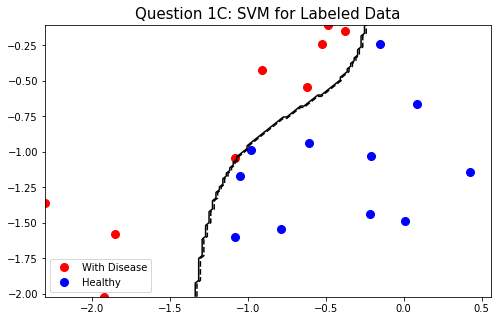

In [7]:
visualize_boundary(X_labeled, y_labeled, model = svclassifier, title = 'Question 1C: SVM for Labeled Data')

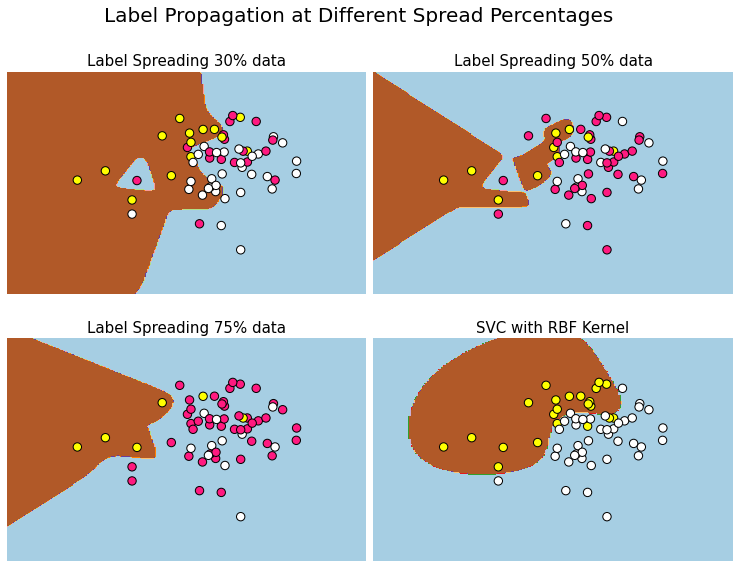

In [8]:
lsvm_plot(ls30, ls50, ls70, rbf_svc)

## <code>Question 2</code>

In [9]:
def convert_binary(df, columns = ['Risk1Yr']):
    for column in columns:
        df[column] = df[column].apply(lambda x: 0 if x == 'F' else 1)
    return df

def load_thoracic(path = '../data/ThoraricSurgery.csv'):
    data = pd.read_csv(path)
    data = data[['PRE4', 'PRE5', 'Risk1Yr']]
    data = convert_binary(data, columns = ['Risk1Yr'])
    X, y = data[['PRE4', 'PRE5']], data['Risk1Yr']
    X, y = X.to_numpy(), y.to_numpy()
    return X, y

X, y = load_thoracic()
X, y = X[0:150, :], y[0:150]

In [10]:
X_labeled, y_labeled = generate_labeled(X, y, rate = 0.68)

In [11]:
svm_train(X_labeled, y_labeled)
print()

              precision    recall  f1-score   support

   No Cancer       0.91      1.00      0.95        40
      Cancer       1.00      0.50      0.67         8

    accuracy                           0.92        48
   macro avg       0.95      0.75      0.81        48
weighted avg       0.92      0.92      0.90        48




In [12]:
y30, ls30 = label_propagate(X, y, rate = 0.30)
y50, ls50 = label_propagate(X, y, rate = 0.50)
y75, ls75 = label_propagate(X, y, rate = 0.75)

rbf_svc = (SVC(kernel = 'rbf', gamma = 0.5).fit(X, y), y)

## <code>Question 3</code>

In [14]:
def create_decisiontree(X, y, include_under = False, k = 2):
    smote = SMOTE(sampling_strategy = 1, k_neighbors = k)
    model = DecisionTreeClassifier()
    under = RandomUnderSampler(sampling_strategy = 1)

    if include_under == True:
        steps = [('over', smote), ('under', under), ('model', model)]
    else:
        steps = [('over', smote), ('model', model)]
    pipeline = Pipeline(steps = steps)
    return pipeline

def validation(X, y, pipeline, k):
    start = time()
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    print(f'Mean ROC-AUC at k = {k}: {np.round(mean(scores), 3)}')
    print(f"\t Fit and predict time: {np.round(time() - start, 3)} seconds")

def main(X, y, include_grids = False, include_under = False):
    kvalues = np.arange(1, 10) if include_grids is True else [3]
    for k in kvalues:
        pipeline = create_decisiontree(X, y, include_under, k = k)
        validation(X, y, pipeline, k)

#### Question 3b. Use a <code>SMOTE</code> transformed version of the dataset + <code>DecisionTreeClassifier</code>

In [15]:
X, y = load_colon()
main(X, y, include_grids = False, include_under = False)

Mean ROC-AUC at k = 3: 0.754
	 Fit and predict time: 8.334 seconds


#### Question 3c. Use a <code>SMOTE</code> transformed version of the dataset combined with <code>undersampling</code> of the majority class + <code>DecisionTreeClassifier</code>

In [16]:
main(X, y, include_grids = False, include_under = True)

Mean ROC-AUC at k = 3: 0.789
	 Fit and predict time: 0.079 seconds


#### Question 3d. Use a <code>SMOTE</code> transformed version of the dataset combined with <code>undersampling</code> of the majority class + <code>grid search</code> k value for SMOTE oversampling for imbalanced classification + <code>DecisionTreeClassifier</code>

In [17]:
main(X, y, include_grids = True, include_under = True)

Mean ROC-AUC at k = 1: 0.793
	 Fit and predict time: 0.089 seconds
Mean ROC-AUC at k = 2: 0.786
	 Fit and predict time: 0.082 seconds
Mean ROC-AUC at k = 3: 0.794
	 Fit and predict time: 0.094 seconds
Mean ROC-AUC at k = 4: 0.789
	 Fit and predict time: 0.101 seconds
Mean ROC-AUC at k = 5: 0.785
	 Fit and predict time: 0.101 seconds
Mean ROC-AUC at k = 6: 0.786
	 Fit and predict time: 0.078 seconds
Mean ROC-AUC at k = 7: 0.801
	 Fit and predict time: 0.081 seconds
Mean ROC-AUC at k = 8: 0.792
	 Fit and predict time: 0.293 seconds
Mean ROC-AUC at k = 9: 0.758
	 Fit and predict time: 0.57 seconds
